In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importing image
im = plt.imread("/home/kushal/Desktop/CMS_Creative_164657191_Kingfisher.jpg")
im.shape

(550, 1140, 3)

1140
550
3.8596491228070176


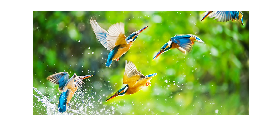

In [3]:
def plti(im, h=8, **kwargs):
    """
    Helper function to plot and image
    """
    y=im.shape[0]
    x=im.shape[1]
    w=(y/x)* h
    print(x)
    print(y)
    print(w)
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')
    
plti(im)    

1140
550
3.8596491228070176


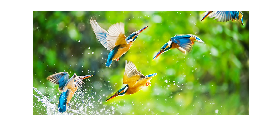

In [4]:
im = im[:3800,:2000,:]
plti(im)

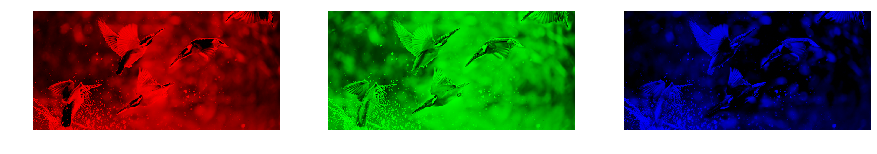

In [5]:
# colors
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for c, ax in zip(range(3), axs):
    tmp_im = np.zeros(im.shape, dtype="uint8")
    tmp_im[:,:,c] = im[:,:,c]
    ax.imshow(tmp_im)
    ax.set_axis_off()


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


1140
550
3.8596491228070176


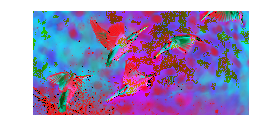

In [6]:
def do_normalise(im):
    return -np.log(1/((1 + im)/257) - 1)
 
def undo_normalise(im):
    return (1 + 1/(np.exp(-im) + 1) * 257).astype("uint8")

def rotation_matrix(theta):
    """
    3D rotation matrix around the X-axis by angle theta
    """
    return np.c_[
        [1,0,0],
        [0,np.cos(theta),-np.sin(theta)],
        [0,np.sin(theta),np.cos(theta)]
    ]

im_normed = do_normalise(im)
im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(np.pi))
im2 = undo_normalise(im_rotated)

plti(im2)

In [7]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(5,8))

def update(i):
    im_normed = do_normalise(im)
    im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    im2 = undo_normalise(im_rotated)
    
    ax.imshow(im2)
    ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, 20), interval=50)
anim.save('colour_rotation.gif', dpi=80, writer='imagemagick')
plt.close()

# <img src="colour_rotation.gif">

MovieWriter imagemagick unavailable. Trying to use pillow instead.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [8]:
from PIL import Image
img = Image.open("colour_rotation.gif").convert('RGB')

# TO GREYSCALE

In [9]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    """
    Transforms a colour image to a greyscale image by
    taking the mean of the RGB values, weighted
    by the matrix weights
    """
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

1140
550
3.8596491228070176


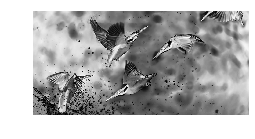

In [10]:
img = to_grayscale(im)

plti(img, cmap='Greys')

# Convoluted

In [11]:

from scipy.ndimage.interpolation import zoom
im_small = zoom(im, (0.2,0.2,1))

228
110
3.8596491228070176


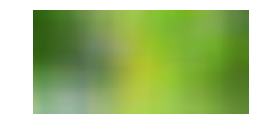

In [12]:
from scipy.signal import convolve2d

def convolve_all_colours(im, window):
    """
    Convolves im with window, over all three colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = convolve2d(im[:,:,d], window, mode="same", boundary="symm")
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

n=50
window = np.ones((n,n))
window /= np.sum(window)
plti(convolve_all_colours(im_small, window))

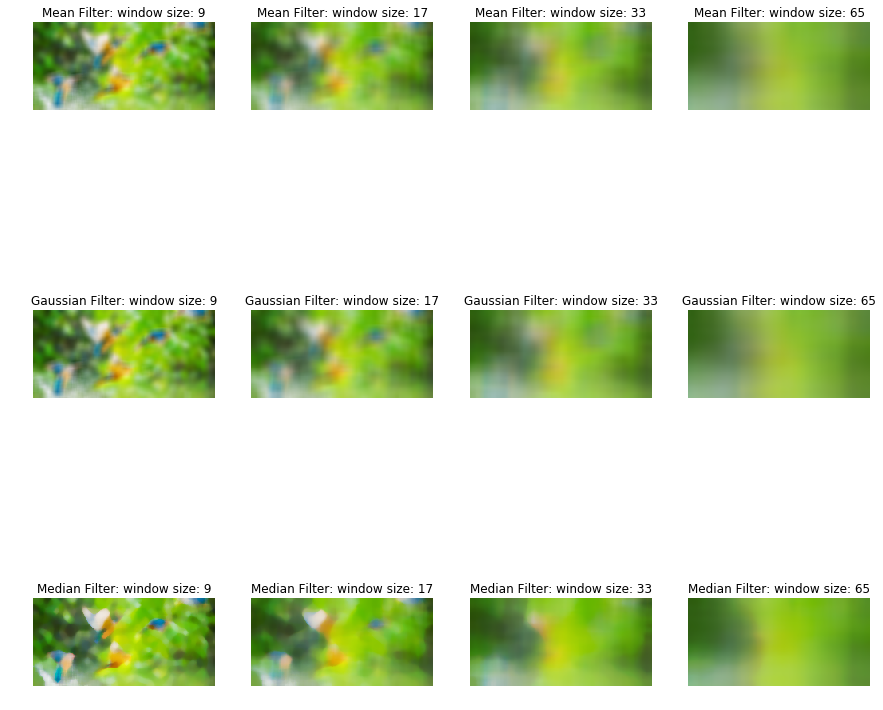

In [13]:
from scipy.ndimage import median_filter

def make_gaussian_window(n, sigma=1):
    """
    Creates a square window of size n by n of weights from a gaussian
    of width sigma.
    """
    nn = int((n-1)/2)
    a = np.asarray([[x**2 + y**2 for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    return np.exp(-a/(2*sigma**2))

def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

window_sizes = [9,17,33,65]
fig, axs = plt.subplots(nrows=3, ncols=len(window_sizes), figsize=(15,15));

# mean filter
for w, ax in zip(window_sizes, axs[0]):
    window = np.ones((w,w))
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Mean Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# gaussian filter
for w, ax in zip(window_sizes, axs[1]):
    window = make_gaussian_window(w,sigma=w)
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Gaussian Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# median filter
for w, ax in zip(window_sizes, axs[2]):
    ax.imshow(median_filter_all_colours(im_small, w));
    ax.set_title("Median Filter: window size: {}".format(w));
    ax.set_axis_off();
    

228
110
3.8596491228070176
CPU times: user 29.6 ms, sys: 3.3 ms, total: 32.9 ms
Wall time: 29.5 ms


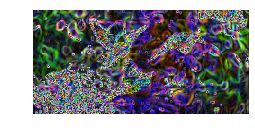

In [14]:
%%time

n=100
sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_small[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_small[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

228
110
3.8596491228070176


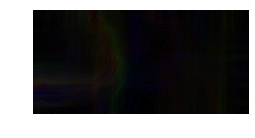

In [15]:
im_smoothed = median_filter_all_colours(im_small, 71)

sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_smoothed[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_smoothed[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

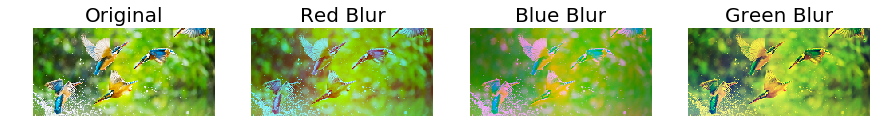

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))

ax= axs[0]
ax.imshow(im_small)
ax.set_title("Original", fontsize=20)
ax.set_axis_off()

w=75
window = np.ones((w,w))
window /= np.sum(window)

ax= axs[1]
ims = []
for d in range(3):
    if d == 0:
        im_conv_d = convolve2d(im_small[:,:,d],window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Red Blur", fontsize=20)
ax.set_axis_off()

ax= axs[2]
ims = []
for d in range(3):
    if d == 1:
        im_conv_d = convolve2d(im_small[:,:,d], window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Blue Blur", fontsize=20)
ax.set_axis_off()

ax= axs[3]
ims = []
for d in range(3):
    if d == 2:
        im_conv_d = convolve2d(im_small[:,:,d], window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Green Blur", fontsize=20)
ax.set_axis_off()

# SEGMENTATION

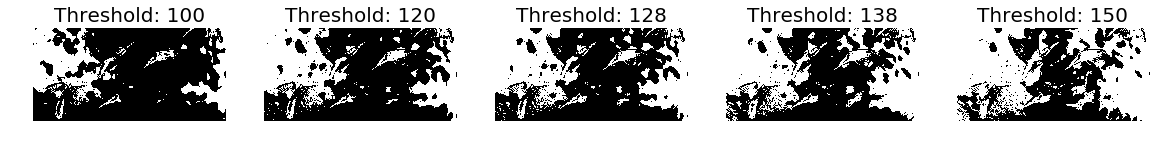

In [17]:
def simple_threshold(im, threshold=128):
    return ((im > threshold) * 255).astype("uint8")

thresholds = [100,120,128,138,150]

fig, axs = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(20,5));
gray_im = to_grayscale(im)
                        
for t, ax in zip(thresholds, axs):
    ax.imshow(simple_threshold(gray_im, t), cmap='Greys');
    ax.set_title("Threshold: {}".format(t), fontsize=20);
    ax.set_axis_off();

1140
550
3.8596491228070176


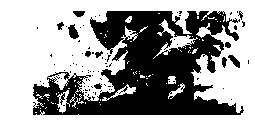

In [18]:
def otsu_threshold(im):

    pixel_counts = [np.sum(im == i) for i in range(256)]

    s_max = (0,-10)
    ss = []
    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0

        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)

        if s > s_max[1]:
            s_max = (threshold, s)
            
    return s_max[0]

t = otsu_threshold(gray_im)
plti(simple_threshold(gray_im, t), cmap='Greys')

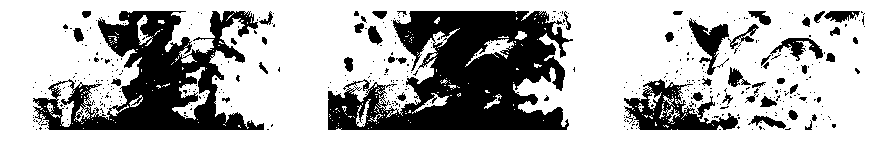

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

c_ims = []
for c, ax in zip(range(3), axs):
    tmp_im = im[:,:,c]
    t = otsu_threshold(tmp_im)
    tmp_im = simple_threshold(tmp_im, t)
    ax.imshow(tmp_im, cmap='Greys')
    c_ims.append(tmp_im)
    ax.set_axis_off()

1140
550
3.8596491228070176


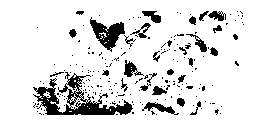

In [20]:
plti(c_ims[0] & c_ims[1] & c_ims[2], cmap='Greys')


228
110
3.8596491228070176


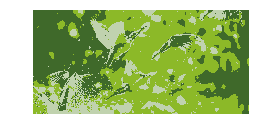

In [21]:
from sklearn.cluster import KMeans

h,w = im_small.shape[:2]
im_small_long = im_small.reshape((h * w, 3))
im_small_wide = im_small_long.reshape((h,w,3))

km = KMeans(n_clusters=3)

km.fit(im_small_long)

cc = km.cluster_centers_.astype(np.uint8)
out = np.asarray([cc[i] for i in km.labels_]).reshape((h,w,3))

plti(out)

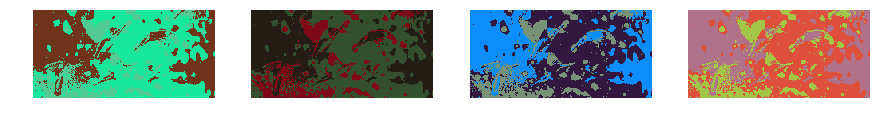

In [22]:
rng = range(4)

fig, axs = plt.subplots(nrows=1, ncols=len(rng), figsize=(15,5))
gray_im = to_grayscale(im)
                        
for t, ax in zip(rng, axs):
    rnd_cc = np.random.randint(0,256, size = (3,3))
    out = np.asarray([rnd_cc[i] for i in km.labels_]).reshape((h,w,3))
    ax.imshow(out)
    ax.set_axis_off()

# VECTORIZATION

228
110
3.8596491228070176


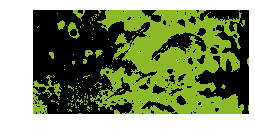

In [23]:
dog = np.asarray([cc[i] if i == 1 else [0,0,0]
                  for i in km.labels_]).reshape((h,w,3))

plti(dog)


In [30]:
class Polygon:
    def __init__(self, outer, inners):
        self.outer = outer
        self.inners = inners
        
    def clone(self):
        return Polygon(self.outer[:], [c.clone() for c in self.inners])

def crosses_line(point, line):
    """
    Checks if the line project in the positive x direction from point
    crosses the line between the two points in line
    """
    p1,p2 = line
    
    x,y = point
    x1,y1 = p1
    x2,y2 = p2
    
    if x <= min(x1,x2) or x >= max(x1,x2):
        return False
    
    dx = x1 - x2
    dy = y1 - y2
    
    if dx == 0:
        return True
    
    m = dy / dx

    if y1 + m * (x - x1) <= y:
        return False
    
    return True

def point_within_polygon(point, polygon):
    """
    Returns true if point within polygon
    """
    crossings = 0
    
    for i in range(len(polygon.outer)-1):
        line = (polygon.outer[i], polygon.outer[i+1])
        crossings += crosses_line(point, line)
        
    if crossings % 2 == 0:
        return False
    
    return True

def polygon_inside_polygon(polygon1, polygon2):
    """
    Returns true if the first point of polygon1 is inside 
    polygon 2
    """
    return point_within_polygon(polygon1.outer[0], polygon2)


    
def subsume(original_list_of_polygons):
    """
    Takes a list of polygons and returns polygons with insides.
    
    This function makes the unreasonable assumption that polygons can
    only be complete contained within other polygons (e.g. not overlaps).
    
    In the case where polygons are nested more then three levels, 
    """
    list_of_polygons = [p.clone() for p in original_list_of_polygons]
    polygons_outside = [p for p in list_of_polygons
                        if all(not polygon_inside_polygon(p, p2) 
                               for p2 in list_of_polygons 
                               if p2 != p)]
    
    polygons_inside = [p for p in list_of_polygons
                        if any(polygon_inside_polygon(p, p2) 
                               for p2 in list_of_polygons
                               if p2 != p)]
    
    for outer_polygon in polygons_outside:
        for inner_polygon in polygons_inside:
            if polygon_inside_polygon(inner_polygon, outer_polygon):
                outer_polygon.inners.append(inner_polygon)
                
    return polygons_outside
                
    for p in polygons_outside:
        p.inners = subsume(p.inners)
        
    return polygons_outside

In [32]:
polygons = [Polygon(p,[]) for p in paths]
subsumed_polygons = subsume(polygons)

NameError: name 'paths' is not defined